In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

is_GPU = torch.cuda.is_available()

if(is_GPU):
  print("Training on GPU")
else:
  print("Training on CPU")

Training on GPU


In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
batch_size = 15

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train_set = datasets.CIFAR10('data', train = True, download=True, transform = transform)
test_set = datasets.CIFAR10('data', train = False, download=True, transform = transform)

train_len = len(train_set)
index = list(range(train_len))
np.random.shuffle(index)
size = int(np.floor(train_len * 0.2))

train_sample = SubsetRandomSampler(index[size:])
validation_sample = SubsetRandomSampler(index[:size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sample, num_workers=1)
validation_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=validation_sample, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


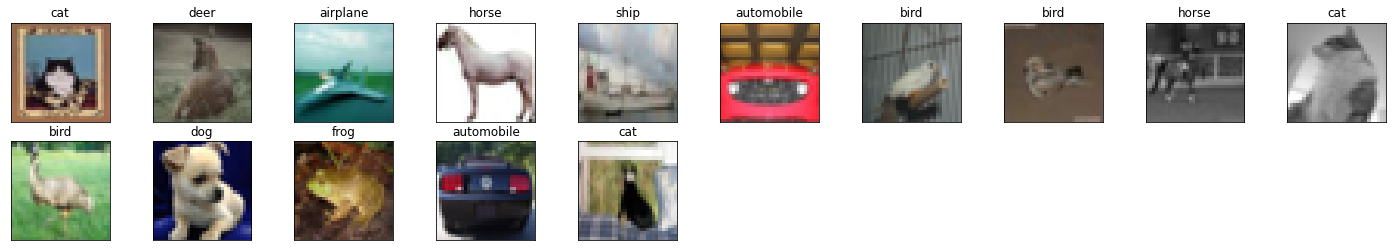

In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

iterator = iter(train_loader)
images, labels = iterator.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))

for i in range(batch_size):
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  img = images[i]/2 + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0)))
  ax.set_title(classes[labels[i]])

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.fc1 = nn.Linear(64*4*4, 500)
    self.fc2 = nn.Linear(500, 128)
    self.fc3 = nn.Linear(128, 10)

    self.maxpool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.maxpool(F.relu(self.conv1(x)))
    x = self.maxpool(F.relu(self.conv2(x)))
    x = self.maxpool(F.relu(self.conv3(x)))

    x = x.view(-1, 64*4*4)

    x = F.relu(self.fc1(self.dropout(x)))
    x = F.relu(self.fc2(self.dropout(x)))
    x = self.fc3(x)

    return x

model = Net()
print(model)

if is_GPU:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [7]:
epochs = 20

min_val_loss = np.Inf

for e in range(1, epochs+1):
  train_loss = 0
  val_loss = 0
  for images, labels in train_loader:
    if is_GPU:
      images, labels = images.cuda(), labels.cuda()
    optimizer.zero_grad()
    output = model(images)

    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * images.size(0)

  model.eval()
  for images, labels in validation_loader:
    if is_GPU:
      images, labels = images.cuda(), labels.cuda()
    output = model(images)
    loss = criterion(output, labels)

    val_loss += loss.item() * images.size(0)

  train_loss = train_loss / len(train_sample)
  val_loss = val_loss / len(validation_sample)

  print(f"Epoch: {e} \tTraining Loss: {train_loss} \tValidation Loss: {val_loss}")

  if(val_loss <= min_val_loss):
    print("Validation Loss decreased")
    print(f"{min_val_loss} ---> {val_loss}")

    min_val_loss = val_loss
    torch.save(model.state_dict(), 'CIFAR-10_model.pt')

Epoch: 1 	Training Loss: 2.236597472280264 	Validation Loss: 2.029551588058472
Validation Loss decreased
inf ---> 2.029551588058472
Epoch: 2 	Training Loss: 1.7642920391708612 	Validation Loss: 1.6797836270928383
Validation Loss decreased
2.029551588058472 ---> 1.6797836270928383
Epoch: 3 	Training Loss: 1.4693894038274884 	Validation Loss: 1.3790981181263924
Validation Loss decreased
1.6797836270928383 ---> 1.3790981181263924
Epoch: 4 	Training Loss: 1.3096156392171978 	Validation Loss: 1.2464855900406837
Validation Loss decreased
1.3790981181263924 ---> 1.2464855900406837
Epoch: 5 	Training Loss: 1.1693274594172836 	Validation Loss: 1.114731747612357
Validation Loss decreased
1.2464855900406837 ---> 1.114731747612357
Epoch: 6 	Training Loss: 1.0549222117364407 	Validation Loss: 1.0876075856536627
Validation Loss decreased
1.114731747612357 ---> 1.0876075856536627
Epoch: 7 	Training Loss: 0.9574246852695942 	Validation Loss: 0.9641844249516726
Validation Loss decreased
1.0876075856536

In [8]:
model.load_state_dict(torch.load('CIFAR-10_model.pt'))

<All keys matched successfully>

In [20]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

test_loss = 0
model.eval()
for images, labels in test_loader:
  if is_GPU:
    images, labels = images.cuda(), labels.cuda()
  output = model(images)
  loss = criterion(output, labels)

  test_loss += loss.item() * images.size(0)

print(f"Test Loss: {test_loss / len(test_set)}")

Test Loss: 0.8497686999738217


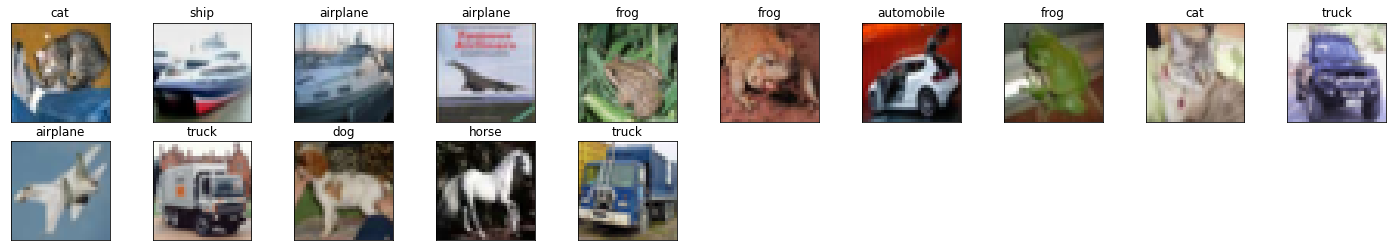

In [25]:
iterator = iter(test_loader)
images, labels = iterator.next()
test_images = images

fig = plt.figure(figsize=(25,4))
model.eval()
if is_GPU:
  test_images = test_images.cuda()
output = model(test_images)
p = torch.argmax(output, dim=1)

images = images.numpy()
for i in range(batch_size):
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  img = images[i]/2 + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0)))
  ax.set_title(classes[p[i]])  